In [1]:
import gudhi as gd
from gudhi import representations
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as st
from collections import defaultdict
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances
from tqdm.notebook import tqdm
import scipy.spatial.distance as spdists
from scipy.optimize import  curve_fit

%matplotlib widget

In [2]:
def sampled_ecc_alpha(pointcloud, n_samples, max_filt_val):
    ac = gd.AlphaComplex(points = pointcloud)
    st = ac.create_simplex_tree()
    filt_values = np.linspace(0,max_filt_val,n_samples)
    ecc_values = np.zeros_like(filt_values)
    simplices = list(st.get_filtration())
    cur_val = 0
    i=0
    for (j,t) in enumerate(filt_values):
        while (i<len(simplices)) and (simplices[i][1]<=t):
            cur_val=cur_val +(-1)**(len(simplices[i][0])-1)
            i = i+1
        #print(t, cur_val)
        ecc_values[j] = cur_val
        
    return ecc_values

In [3]:
def get_ecc(data, n_samples, max_filt_val):
    eccs = []
    for dat in tqdm(data):
        ec = sampled_ecc_alpha(dat, n_samples, max_filt_val)
        eccs.append(ec)
    return eccs

In [4]:
def gen_rv(rv, N, n_samples):
        return [np.array([rv[0].rvs(N), rv[1].rvs(N).tolist(), rv[2].rvs(N).tolist()]).T for i in range(n_samples)]

In [5]:
def tail_frequency(array, t):
    #how often are elements of array >t?
    return (np.sum(array>t)/len(array))

In [6]:
rv_normal = st.norm()
rv_normal2_2 = st.norm(2,2)
rv_beta2_2 = st.beta(2, 2)
rv_beta5_5 = st.beta(5, 5)
rv_beta10_10 = st.beta(10, 10)
rv_laplace = st.laplace()
rv_uniform = st.uniform()
rv_t3 = st.t(df=3)
rv_t5 = st.t(df=5)
rv_t7 = st.t(df=7)
rv_t10 = st.t(df=10)
rv_gamma10_1 = st.gamma(10,1)
rv_gamma20_1 = st.gamma(20,1)
rv_gamma4_5 = st.gamma(4,5)
rv_gamma5_1= st.gamma(5,1)
rv_chisq4 = st.chi2(df=4)
rv_chisq10 = st.chi2(df=10)
rv_lorentz = st.cauchy()
rv_logistic = st.logistic()
rv_arcsine = st.arcsine()
rv_argus = st.argus(chi=1)
rv_cosine = st.cosine()


In [7]:
n=200
n_loops = 1000
d = 3

rvs= [[rv_uniform, rv_uniform, rv_uniform],
      [rv_beta2_2, rv_beta2_2, rv_beta2_2],
      [rv_beta5_5, rv_beta5_5,rv_beta5_5],
      [rv_beta10_10, rv_beta10_10, rv_beta10_10],
      [rv_argus, rv_argus, rv_argus],
      [rv_arcsine, rv_arcsine, rv_arcsine],
      [rv_uniform, rv_beta10_10, rv_beta10_10],
      [rv_uniform, rv_uniform, rv_beta10_10],
      [rv_normal, rv_normal, rv_normal]]

rv_names=["UxUxU",
          "B22xB22XB22",
          "B55xB55xB55",
          "B1010xB1010xB1010",
          "ArgusxArgusxArgus",
          "asinxasinxasin",
          "UxB1010xB1010",
          "UxUxB1010",
          "NxNxN"]

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive", "tab:cyan"]


In [8]:
samples = [(n**(1/3)) * np.array(gen_rv(rv,n,n_loops)) for rv in tqdm(rvs)]
samples2 = [(n**(1/3)) * np.array(gen_rv(rv,n,n_loops)) for rv in tqdm(rvs)]

In [9]:
n_vals = np.array([50,100,150,200,250,300,350,400,450,500])
ecc_dists = np.zeros((len(rvs),len(n_vals), n_loops))
#ecc_dists = np.zeros((len(rvs),n_loops))
for j in tqdm(range(0,len(n_vals))):
    n = n_vals[j]
    samples = [(n**(1/3)) * np.array(gen_rv(rv,n,n_loops)) for rv in tqdm(rvs)]
    samples2 = [(n**(1/3)) * np.array(gen_rv(rv,n,n_loops)) for rv in tqdm(rvs)]
    eccs1 = np.array([get_ecc(s, 101,0.5) for s in samples])
    eccs2 = np.array([get_ecc(s, 101,0.5) for s in samples2])

    eccs_mean = np.mean(eccs1, axis =1)

    for i in tqdm(range(0,len(samples))):
        ecc_dists[i][j] = pairwise_distances(eccs_mean[i].reshape(1,-1), eccs2[i], n_jobs = -1, metric = spdists.chebyshev)

In [10]:
ecc_dists[0][0].std()

2.0918239150741154

In [11]:
def func(X,a):
    x = X[0]
    n = X[1]
    return 2 * np.exp(-a*x**2 /n)

In [13]:
f,axs = plt.subplots(len(rvs), 1, figsize =(8,64))
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive", "tab:cyan"]
for i in range(0,len(rvs)):
    axs[i].set_ylabel(rv_names[i])
    for j in range(0,len(n_vals)):
        ts = np.linspace(0, np.max(ecc_dists[i])/np.sqrt(n_vals[j]),100)
        axs[i].plot(ts,[tail_frequency(ecc_dists[i][j]/np.sqrt(n_vals[j]), t) for t in ts], label = n_vals[j], c=colors[j])
        #popt, pcov = curve_fit(func, [ts, [n_vals[j]]*len(ts)], [tail_frequency(ecc_dists[i][j],t) for t in ts], bounds=(0, 5))
        #axs[i].plot(ts,func([ts,[n_vals[j]]*len(ts)], *popt), c=colors[j], ls="--")

    
    axs[i].legend()
    axs[i].set_ylim((-0.1,1.1))
    

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
def func(X, a, b):
    x = X[0]
    n= X[1]
    return 2*np.exp(-a*(x+0*n)**2/n)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

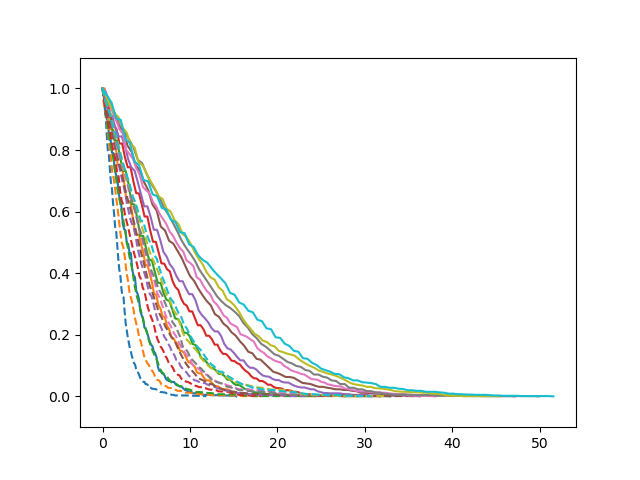

In [14]:
n_vals = np.array([50,100,150,200,250,300,350,400,450,500])
tailfreqs = []
beta_tailfreqs = []
stds = []
beta_stds = []

t_arrays = []
bt_arrays = []

f,ax = plt.subplots()
a_vals = []
b_vals = []
max_abs_difs = np.zeros_like(n_vals)

for j in tqdm(range(0,len(n_vals))):
    n = n_vals[j]
    rv = rvs[2]
    samplesUnif = (n**(1/3)) * np.array(gen_rv(rv,n,n_loops))
    rv=rvs[3]
    samplesBetaTrain = (n**(1/3)) * np.array(gen_rv(rv,n,n_loops))
    samplesBetaTest = (n**(1/3)) * np.array(gen_rv(rv,n,n_loops))
    eccsUnif = get_ecc(samplesUnif, 101,0.9)
    eccsBetaTrain = get_ecc(samplesBetaTrain, 101,0.9)
    eccsBetaTest = get_ecc(samplesBetaTest, 101,0.9)
    eccsBetaTest2 = get_ecc(samplesBetaTest, 101,0.9)

    eccs_unif_mean = np.mean(eccsUnif, axis= 0)
    eccs_beta_mean = np.mean(eccsBetaTrain, axis = 0)
    
    ecc_dists_unif_beta_train = pairwise_distances(eccs_unif_mean.reshape(1,-1), eccsBetaTrain, n_jobs = -1, metric = spdists.chebyshev)
    ecc_dists_unif_beta_test = pairwise_distances(eccs_unif_mean.reshape(1,-1), eccsBetaTest, n_jobs = -1, metric = spdists.chebyshev)
    ecc_dists_beta_mean_test = pairwise_distances(eccs_beta_mean.reshape(1,-1), eccsBetaTest, n_jobs = -1, metric = spdists.chebyshev)
    ecc_dists_beta_mean_test2 = pairwise_distances(eccs_beta_mean.reshape(1,-1), eccsBetaTest2, n_jobs = -1, metric = spdists.chebyshev)
    
    deviation_from_avg = np.abs(ecc_dists_unif_beta_test - np.mean(ecc_dists_unif_beta_train))
    beta_deviation_from_avg = np.abs(ecc_dists_beta_mean_test - np.mean(ecc_dists_beta_mean_test2))
    
    ts = np.linspace(0, np.max(deviation_from_avg[0]),100)
    bts = np.linspace(0, np.max(beta_deviation_from_avg[0]),100)
    t_arrays.append(ts)
    bt_arrays.append(bts)
    tailfreqs.append([tail_frequency(deviation_from_avg[0],t) for t in ts])
    beta_tailfreqs.append([tail_frequency(beta_deviation_from_avg[0],t) for t in bts])
    stds.append(np.std(deviation_from_avg[0]))
    beta_stds.append(np.std(beta_deviation_from_avg[0]))
    
    ax.plot(ts, [tail_frequency(deviation_from_avg[0],t) for t in ts], c= colors[j])
    ax.plot(bts, [tail_frequency(beta_deviation_from_avg[0],t) for t in bts], c= colors[j], ls = "--")
    #popt, pcov = curve_fit(func, [ts, [n_vals[j]]*len(ts)], [tail_frequency(deviation_from_avg[0],t) for t in ts], bounds=(0, [5,0.1]))
    #ax.plot(ts,func([ts,np.array([n_vals[j]]*len(ts))], *popt), c=colors[j], ls="--")
    #ax.plot(ts,2*np.exp(-3*ts**2/(n_vals[j])), c=colors[j], ls="--")
    ax.set_ylim((-0.1,1.1))
    #a_vals.append(popt[0])
    #b_vals.append(popt[1])
    max_abs_difs[j] = np.max(np.abs(np.mean(eccsBetaTrain, axis = 0)-eccs_unif_mean))
    
plt.show()

In [10]:

f,ax = plt.subplots()
for i in range(0,len(n_vals)):
    ax.plot(t_arrays[i], tailfreqs[i], label = n_vals[i], c = colors[i])
    ax.plot(bt_arrays[i], beta_tailfreqs[i], c = colors[i], ls = "--")
    #ax.plot(t_arrays[i], 2*np.exp(-t_arrays[i]**2/n_vals[i]), c=colors[i], label = "exp upper bound", ls = ":")
#ax.plot(ts, 2*np.exp(-0.005*(ts-2*max_abs_difs[-1])**2/n_vals[j]), ls="--")
ax.legend()
ax.set_title("$P(|\|\chi(Y)-E_P\|-E(\|\chi(Y)-E_P\|)|>t)$ vs $P(|\|\chi(Y) - E_Q\|-E(\|\chi(Y)-E_Q\|)|>t)$")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 't_arrays' is not defined

In [19]:
def func(x, a):
    return a*np.sqrt(x)

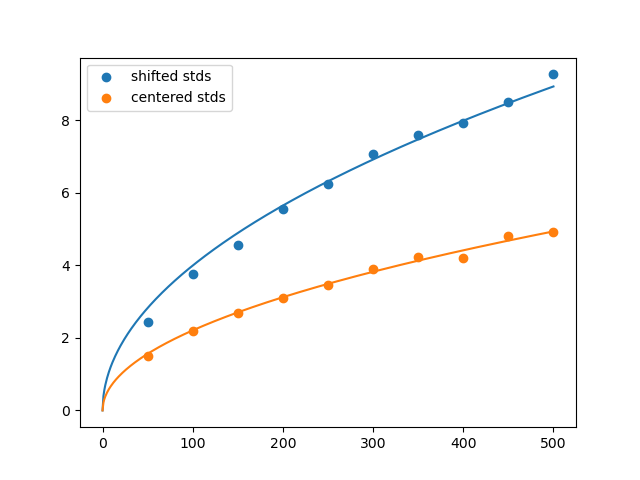

In [21]:
popt, pcov = curve_fit(func, n_vals, stds, bounds=(0, 5))
bopt, bcov = curve_fit(func, n_vals, beta_stds, bounds=(0, 5))

f,ax = plt.subplots()
ax.scatter(n_vals, stds, label = "shifted stds")
ax.scatter(n_vals, beta_stds, label = "centered stds")
x = np.linspace(0,500,501)
ax.plot(x, func(x,popt))
ax.plot(x, func(x,bopt))
ax.legend()
plt.show()

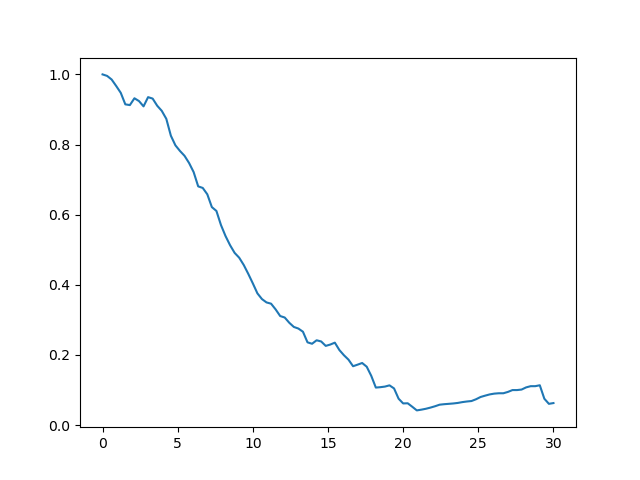

In [17]:
from scipy import interpolate
i=-1
f = interpolate.interp1d(t_arrays[i], tailfreqs[i])
g = interpolate.interp1d(bt_arrays[i], beta_tailfreqs[i])
fig,ax = plt.subplots()
x=np.linspace(0,30,100)
ax.plot(x,g(x)/f(x))
plt.show()

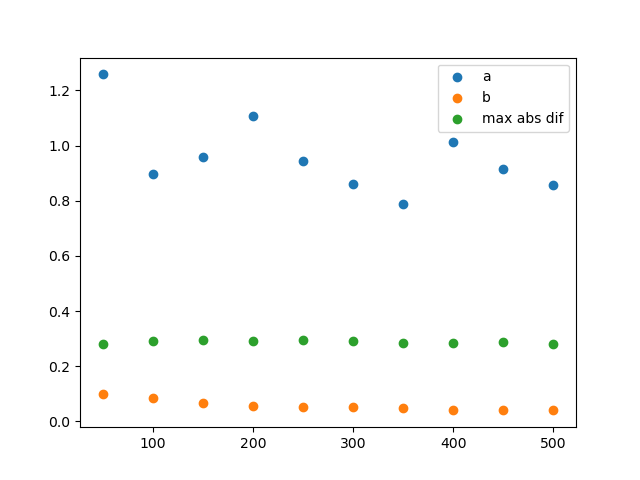

In [17]:
f,ax = plt.subplots()
ax.scatter(n_vals, a_vals, label="a")
ax.scatter(n_vals, b_vals, label="b")
ax.scatter(n_vals, max_abs_difs/n_vals, label = "max abs dif")
ax.legend()
plt.show()

In [104]:
print(a_vals)
print(b_vals)
print(max_abs_difs)

[1.2637774712702503, 0.9492599193951576, 0.9822911083705168, 0.8744260610211897, 0.7458925218667892, 0.8097794355719419, 0.8393698665460819, 0.6852388716253891, 1.0080281134590712, 0.69021529453798]
[0.09999999999999999, 0.08658758680075888, 0.06915197737343678, 0.06115300020587013, 0.06060192713403648, 0.052527437052685144, 0.04738312350881669, 0.0502917663430039, 0.03903971835709629, 0.044687719757309424]
[ 14  29  45  57  71  86 101 114 129 140]


In [114]:
print(deviation_from_avg[0])
ecc_mean_beta_train = np.mean(eccsBetaTrain, axis = 0)
ecc_dists_beta_test_to_mean_beta_train = pairwise_distances(ecc_mean_beta_train.reshape(1,-1), eccsBetaTest, n_jobs = -1, metric = spdists.chebyshev)
deviation_from_Q_avg = np.abs(ecc_dists_beta_test_to_mean_beta_train[0]-np.mean(ecc_dists_beta_test_to_mean_beta_train))
print(deviation_from_Q_avg)

[ 7.28645 17.71355  8.71355  6.28645 14.28355 16.77855  6.16355 11.15355
 15.50355 28.15355 14.91645 23.85145  1.46355  0.85855  2.28355  7.46355
  9.22145  4.49645  5.93145  5.77855  5.53645 12.50355 15.22145 18.50355
 13.22145  5.22145 11.80145 31.77855 27.14145 10.49645  7.85855 19.22145
  7.22145 20.28645  8.85855 36.15355 11.15355  2.28355 17.19855  0.53645
  2.19855 19.19855  8.80145  2.08355  5.80145 11.83645 12.14145 12.27145
  8.80145  7.22145 17.49645  2.80145  4.84645 18.71355 15.71355 22.71355
 16.22145  1.22145 10.77855 13.49645 14.22145  0.77855 23.28645 27.80145
  3.28645  9.71355 14.19855 21.80145 15.83645  0.91645 15.19855  4.15355
  9.77855  3.28645 15.71355 14.84645  2.49645 22.83645 10.08355 17.80145
  7.85855  2.77855  0.22145 12.28645  0.71355  0.49645 30.22145  7.53645
  8.71355 21.50355  6.85855  1.22145 10.50355 10.22145  5.22145  7.71355
  1.22145 17.15355  4.27145  9.50355  3.49645 40.77855  3.19855 12.77855
  6.84645 24.71355 10.46355  5.19855  0.77855 10.15

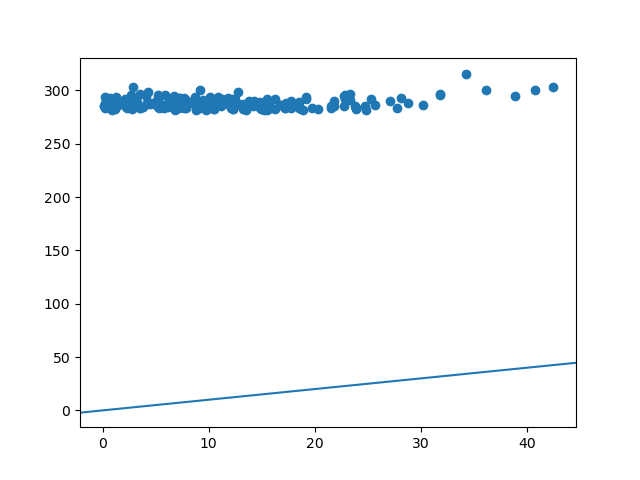

In [119]:
f,ax = plt.subplots()
#ax.scatter(range(0,len(deviation_from_avg[0])), deviation_from_avg)
ax.scatter(deviation_from_avg, deviation_from_Q_avg+2*np.max(np.abs(np.mean(eccsBetaTrain, axis = 0)-eccs_unif_mean)))
ax.axline((0,0), slope = 1)
plt.show()